<a href="https://colab.research.google.com/github/MaiAbdelhameed/Regex-to-Min-DFA/blob/main/Compilers_Assignment_DFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation

## Part 1: Regex to NFA

### regex manipulation

Example:
- handle concatination ✔
- handle ranges ✔

In [159]:
global input_lists
input_lists = set()

In [160]:
def check_ranges(st): # range be ma3na ay haga gowa for ex: [a-z] [abc] [ast] [a-z|0|1|2]     ASSUMPTION: only chars inside range (those will not be considered as operators *?|+∘) only opreator is -
    res = []
    l = [char for char in st]
    operators = ['*','?','|','+','∘']


    for ind, ch in enumerate(l):
        if ch == '-':
            if ind == 0: # -a
                return False

                # a-                -a                  a-                  *-                      -#
            if  (ind == len(l)-1) or not l[ind-1] or not l[ind+1] or not l[ind-1].isalnum() or not l[ind+1].isalnum(): # error checking handles a- or a--
                return False

            if l[ind+1].isalpha() and l[ind-1].isalpha():

                if (l[ind-1].islower() and l[ind+1].isupper()) or (l[ind+1].islower() and l[ind-1].isupper()): #handling a-Z A-b mismatch
                    return False

                if (l[ind-1] > l[ind+1]): #handling c-a or C-A
                    return False

            elif l[ind+1].isdigit() and l[ind-1].isdigit():
                if (int(l[ind-1]) > int(l[ind+1])): # handle [9-0]
                    return False

            else: #error checkin handles a-9 or 1-z mismatch
                return False

    return ''.join(l)

print(check_ranges("ab[a-zA-z0-9]"))

False


In [161]:
def brackets_balanced(s):
    count_open = 0
    count_close = 0

    for char in s:
        if char == '[':
            count_open += 1
        elif char == ']':
            count_close += 1

    return count_open == count_close


In [162]:
def regex_ranges(st):  # [a-c] => [a|b|c] ab        #ab[a-z]
    l = [char for char in st]
    range_dict = {}
    flag = 0
    postfix = ''
    range = ''

    # check [ = ]
    if not brackets_balanced(st): return False

    for ind, c in enumerate(l):
        if c == '[':
            range = ''
            flag = 1
            postfix += c
            continue

        if c == ']':
            flag = 0
            res = check_ranges(range)
            if not res: return False
            postfix += res
            postfix += c
            continue

        if flag == 1:
            range += c
            continue

        postfix += c

    return postfix


# print(regex_ranges('[1-9]|[1-9][0-9]|1[0-9][0-9]|2[0-4][0-9]|25[0-5]'))
print(regex_ranges('ab[a-zA-z0-9]'))

False


In [163]:
def regex_anding(st): #A?∘B
    and_op = '∘'
    l = [char for char in st]
    flag = 0
    #handle anding
    for ind, ch in enumerate(l):

        one_operand = ['+', '*', '?']
        two_operands = ['|', '∘']
        brackets = ['[', ']', '(', ')']
        # to skip adding & inside a range (skip paranthesis)

        if ch == ']':
            flag = 0

        if flag ==1:
            continue

        if ind != len(l)-1 and (ch == '['):
            flag = 1


        # cases: ab => a∘b          a( => a∘(           a[ => a∘[           a% => a∘%
        if ind != len(l)-1 and ch.isalnum() and (l[ind+1] not in ['?', '+', '*', '∘', '|', ')', ']']):
            l.insert(ind+1, and_op)

        # cases: a+b => a+∘b
        elif ind != len(l)-1 and not ch.isalnum() and l[ind+1].isalnum() and ch not in ['∘', '[', '-', '(', '|']:
            l.insert(ind+1, and_op)

        #cases: handle *? => *?
        elif ind != len(l)-1 and not ch.isalnum() and not l[ind+1].isalnum() and ch in one_operand and l[ind+1] in one_operand:
            continue

        elif ind != len(l)-1 and not ch.isalnum() and not l[ind+1].isalnum() and ch in one_operand and l[ind+1] in [')']:
            continue

        # ?( => ?∘(
        elif ind != len(l)-1 and not ch.isalnum() and not l[ind+1].isalnum() and ch not in ['∘', '[', '-', '(', '|', ')', ']'] and l[ind+1] != '|' and l[ind+1] != ')':
            l.insert(ind+1, and_op)

        # cases: )(     ][      ](      )[  => )∘(      ]∘[     ]∘(        )∘[
        elif ind != len(l)-1 and (ch == ')' or ch == ']') and (l[ind+1] in ['[', '('] or ( l[ind+1] not in one_operand and l[ind+1] not in two_operands and l[ind+1] not in [')', ']'])):
            l.insert(ind+1, and_op)


    return ''.join(l)


# print(regex_anding('[1-9]|[1-9][0-9]|1[0-9][0-9]|2[0-4][0-9]|25[0-5]'))
# print(regex_anding('((ABC)|(abc))'))

### Shaunting Yard

In [164]:
from collections import deque

def shaunting_yard(st):
    prec = {'*' : 5, '+' :4, '?': 3, '∘': 2, '|' : 1}
    st1 = regex_ranges(st)
    if not st1:
        return "Invalid Regex"

    st2 = regex_anding(st1)

    stack = []
    queue = deque()
    flag = 0
    regex = ''
    for ch in st2: # number

        if ch == '[':
            flag = 1
            regex += ch
            continue

        if ch == ']':
            regex +=ch
            queue.append(regex)
            flag = 0
            regex = ''
            continue

        if flag == 1:
            regex +=ch
            continue


        if ch not in ['?', '+', '*', '∘', '|', '(', ')',]:
            queue.append(ch)

        elif ch == '(':
            stack.append(ch)

            #right paranthesis
        elif ch == ")": # handle ab)
            while stack and stack[-1] != "(":
                queue.append(stack.pop())
            if not stack: # error checking no ( in stack
                return "Invalid Regex"
            stack.pop()


        elif ch in prec.keys():
            while stack and prec[ch] <= prec.get(stack[-1], 0):
                queue.append(stack.pop())
            stack.append(ch)

    while stack: #
        if stack[-1] == '(' or stack[-1] == '[': # error checking ( remaining in stack
            return "Invalid Regex"
        queue.append(stack.pop())


    output_shaunting_yard = ''.join(queue)


    with open('inner_data.txt', 'w') as file:
        # Write text to the file
        file.write("original regex = " + st + '\n\n')
        file.write("regex after handling concat = " + st2 + '\n\n')
        file.write("regex after shaunting yard  = " + output_shaunting_yard + '\n\n')


    return output_shaunting_yard

# regex = 'ab[a-zA-Z0-9]'
# output_queue = shaunting_yard(regex)
# print(output_queue)


### Postfix to NFA

classes: Edges, State, NFA

In [165]:
class Edge:
    def __init__(self, _label, _source, _destination):
        self.label = _label
        self.source = _source
        self.destination = _destination

    def get_label(self):
        return self.label

    def get_source(self):
        return self.source

    def get_destination(self):
        return self.destination

    def __str__(self):
        return f'Edge with label {self.label} from {self.source} to {self.destination}'



class State:
    def __init__(self, _label, _state_type):
        self.label = _label
        self.state_type = _state_type
        self.outgoing_edges = []
        self.isTerminal = False

    def add_outgoing_edge(self, edge):
        self.outgoing_edges.append(edge)


    def get_outgoing_edges(self):
        return self.outgoing_edges




class NFA:
    def __init__(self, _NFA_type, _starting_state, _inner_states, _accepting_state):
        self.NFA_type = _NFA_type
        self.starting_state = _starting_state
        self.inner_states = [item for sublist in _inner_states if isinstance(sublist, list) for item in sublist] + [item for item in _inner_states if not isinstance(item, list)]
        self.accepting_state = _accepting_state

    def __str__(self):
        return f'The NFA type is {self.NFA_type} and has starting state = {self.starting_state.label}, {len(self.inner_states)} inner states, and accepting state = {self.accepting_state.label}'



    +, *, ? => pop once
    ∘, | => pop twice






In [166]:
epsilon = 'ε'

def construct_variable_NFA(char):
    global state_count

    #states
    var_state = State(f'S{state_count}', 'variable')
    state_count+=1
    state = State(f'S{state_count}', epsilon)
    state_count+=1

    #edges
    edge = Edge(char, var_state, state)

    #connecting edges to states
    var_state.add_outgoing_edge(edge)

    #construct NFA
    nfa = NFA('Variable',var_state, [] , state )

    return nfa


def construct_concat_nfa(var1, var2):

    #edges
    edge = Edge(epsilon ,var1.accepting_state, var2.starting_state)

    #connecting edges to states
    var1.accepting_state.add_outgoing_edge(edge)

    #construct NFA
    nfa = NFA('Concatination', var1.starting_state, [var1.inner_states , var1.accepting_state , var2.starting_state , var2.inner_states] ,var2.accepting_state)

    return nfa


def construct_or_nfa(var1, var2):

    global state_count

    # if var1.NFA_type == 'Oring':
    #     edge1 = Edge(epsilon, var1.starting_state, var2.starting_state)
    #     edge2 = Edge(epsilon, var2.accepting_state, var1.accepting_state)
    #     var1.starting_state.add_outgoing_edge(edge1)
    #     var2.accepting_state.add_outgoing_edge(edge2)
    #     nfa = NFA('Oring', var1.starting_state, [var1.inner_states, var2.starting_state, var2.accepting_state], var1.accepting_state)
    #     return nfa

    #states
    state = State(f'S{state_count}', epsilon)
    state_count+=1
    state1 = State(f'S{state_count}', epsilon)
    state_count+=1


    #edges
    edge1 = Edge(epsilon, state, var1.starting_state)
    edge2 = Edge(epsilon, state, var2.starting_state)
    edge3 = Edge(epsilon, var1.accepting_state, state1)
    edge4 = Edge(epsilon, var2.accepting_state, state1)

    ##connecting edges to states
    state.add_outgoing_edge(edge1)
    state.add_outgoing_edge(edge2)
    var1.accepting_state.add_outgoing_edge(edge3)
    var2.accepting_state.add_outgoing_edge(edge4)

    #construct NFA
    nfa = NFA('Oring', state, [var1.starting_state , var1.inner_states , var1.accepting_state , var2.starting_state , var2.inner_states , var2.accepting_state] ,state1)

    return nfa


def construct_zero_or_more_nfa(var):

    global state_count

    #states
    state = State(f'S{state_count}', epsilon)
    state_count+=1
    state1 = State(f'S{state_count}', epsilon)
    state_count+=1

    #edges
    edge1 = Edge(epsilon, state, var.starting_state)
    edge2 = Edge(epsilon, var.accepting_state, var.starting_state)
    edge3 = Edge(epsilon, var.accepting_state, state1)
    edge4 = Edge(epsilon, state, state1)

    #connecting edges to states
    state.add_outgoing_edge(edge1)
    var.accepting_state.add_outgoing_edge(edge2)
    var.accepting_state.add_outgoing_edge(edge3)
    state.add_outgoing_edge(edge4)

    #construct NFA
    nfa = NFA('Zero Or More', state, [var.starting_state , var.inner_states , var.accepting_state] ,state1)

    return nfa


def construct_one_or_more_nfa(var):

    global state_count

    #states
    start_state = State(f'S{state_count}', epsilon)
    state_count+=1
    end_state = State(f'S{state_count}', epsilon)
    state_count+=1

    #edges
    edge1 = Edge(epsilon, start_state, var.starting_state)
    edge2 = Edge(epsilon, var.accepting_state, var.starting_state)
    edge3 = Edge(epsilon, var.accepting_state, end_state)

    #connecting edges to states
    start_state.add_outgoing_edge(edge1)
    var.accepting_state.add_outgoing_edge(edge2)
    var.accepting_state.add_outgoing_edge(edge3)

    #construct NFA
    nfa = NFA('One Or More', start_state, [var.starting_state , var.inner_states , var.accepting_state] , end_state)

    return nfa


def construct_zero_or_one_nfa(var):

    global state_count

    #states
    state = State(f'S{state_count}', epsilon)
    state_count+=1
    state1 = State(f'S{state_count}', epsilon)
    state_count+=1

    #edges
    edge1 = Edge(epsilon, state, var.starting_state)
    edge3 = Edge(epsilon, var.accepting_state, state1)
    edge4 = Edge(epsilon, state, state1)

    #connecting edges to states
    state.add_outgoing_edge(edge1)
    var.accepting_state.add_outgoing_edge(edge3)
    state.add_outgoing_edge(edge4)


    nfa = NFA('Zero Or One (Optional)', state, [var.starting_state , var.inner_states , var.accepting_state] ,state1)

    return nfa


In [167]:
def postfix_to_NFA(st): # a[a-z]o
    stack = []
    global state_count
    state_count = 0
    flag = 0
    range = ''
    try:
        for c in st:

            if c == '[':
                flag = 1
                range += c
                continue

            if c == ']':
                range += c
                nfa = construct_variable_NFA(range)
                stack.append(nfa)
                flag = 0
                range = ''
                continue

            if flag == 1:
                range +=c
                continue


            if c.isalnum() or c not in ['?', '+', '*', '∘', '|']:

                nfa = construct_variable_NFA(c)

                #add nfa to stack
                stack.append(nfa)

            elif c == '∘':

                var1 = stack.pop()
                var2 = stack.pop()

                nfa = construct_concat_nfa(var2, var1)


                stack.append(nfa)

            elif c == '|':

                var1 = stack.pop()
                var2 = stack.pop()

                nfa = construct_or_nfa(var2, var1)

                stack.append(nfa)

            elif c == '*':

                var = stack.pop()

                nfa = construct_zero_or_more_nfa(var)

                stack.append(nfa)

            elif c == '+':

                var = stack.pop()

                nfa = construct_one_or_more_nfa(var)

                stack.append(nfa)

            elif c == '?':

                var = stack.pop()

                nfa = construct_zero_or_one_nfa(var)

                stack.append(nfa)

        if len(stack) != 1:
            return "Invalid Regex"

        nfa = stack.pop()
        nfa.accepting_state.isTerminal = True       #check ba3deen for terminal states

    except Exception as e:
        return "Invalid Regex"

    return nfa

out = shaunting_yard('ab[a-zA-z0-9]')

nfa = postfix_to_NFA(out)
print(str(nfa))

Invalid Regex


### NFA Graph

In [168]:
import graphviz
from graphviz import Digraph
from IPython.display import display, Image

def visualize_NFA(nfa):

    start_state = nfa.starting_state
    inner_states = nfa.inner_states
    accept_state = nfa.accepting_state

    graph = Digraph(graph_attr={'rankdir': 'LR'})
    # handle start edge -> S0 ✔
    graph.node("", _attributes = {'shape':'none'})
    graph.edge("", start_state.label, label = "start")

    all_nodes = [start_state] + inner_states + [accept_state]

    all_edges = []

    for node in all_nodes:

        if not node.get_outgoing_edges(): ## accepting
            graph.node(node.label, _attributes = {'peripheries' : '2'})
        else:
            graph.node(node.label)

        all_edges.extend(node.get_outgoing_edges())



    for edge in all_edges:
        graph.edge(edge.source.label, edge.destination.label, label = edge.label)
        input_lists.add(edge.label)



    return graph



# nfa = postfix_to_NFA('A*B∘')
# graph = visualize_NFA(nfa)
# print(graph.source)
# graph.render('graph', format = 'png', cleanup = True, view = True)
# display(Image('graph.png'))


In [169]:
import json
def get_output_json(nfa):
    epsilon = 'ε'
    start_state = nfa.starting_state
    inner_states = nfa.inner_states
    accept_state = nfa.accepting_state
    all_nodes = [start_state] + inner_states + [accept_state]
    json_dictionary = dict()
    json_dictionary['startingState'] = start_state.label

    for node in all_nodes:
        node_dictionary= dict()
        node_dictionary["isTerminatingState"] = node.isTerminal
        for e in node.outgoing_edges: # handle epsilon and multiple states (more than one state are in a list)
            #handle multiple states and edges ex: epslin: s1,s2
            if e.label not in node_dictionary:
                node_dictionary[e.label] = []  # Create an empty list if key doesn't exist
            node_dictionary[e.label].append(e.destination.label)


        # Check if the list has length 1
        # for key, value in node_dictionary.items():
        #     if key != 'isTerminatingState' and len(value) == 1:
        #         node_dictionary[key] = value[0]

        json_dictionary[node.label] = node_dictionary

    with open('data.json', 'w') as json_file:
        json.dump(json_dictionary, json_file, indent = 6, ensure_ascii=False)

    return json_dictionary

In [170]:
def regex_to_NFA_graph(st):

    output_queue = shaunting_yard(st)
    if output_queue == 'Invalid Regex':
        return output_queue

    nfa = postfix_to_NFA(output_queue)
    if nfa == 'Invalid Regex':
        return nfa
    print(str(nfa))
    graph = visualize_NFA(nfa)
    json_dict = get_output_json(nfa)
    graph.render('NFA_graph', format = 'png', cleanup = True, view = True)
    display(Image('NFA_graph.png'))
    print()
    return nfa

nfa = regex_to_NFA_graph('ab[a-zA-z0-9]')


## Part 2: NFA To Minimized DFA


### Subset Construction Algorithm

In [171]:
class DFA:
    def __init__(self):
        self.starting_state = []
        self.inner_states = []
        self.accepting_state = []

    def __str__(self):
        return f'The DFA has {len(self.starting_state)} starting states, {len(self.inner_states)} inner states, and {len(self.accepting_state)} accepting state'


    def get_state(self, label):
        all_states = list(set((self.starting_state + self.inner_states + self.accepting_state)))
        for s in all_states:
            if s.label == label:
                return s

    def delete_state(self, state):
        if state in self.starting_state:
            self.starting_state.remove(state)

        if state in self.inner_states:
            self.inner_states.remove(state)

        if state in self.accepting_state:
            self.accepting_state.remove(state)

        return


In [172]:
def epsilon_closure(state_list, json_dict):
    for state in state_list:
        if epsilon in json_dict[state].keys():
            state_list  += [elem for elem in json_dict[state][epsilon] if elem not in state_list]
    return state_list

# print(epsilon_closure(['S6'], data))

In [173]:
def get_states_dfa(inp, states_list, json_dict, states_dfa):
    temp_state = []
    if inp != epsilon:
        for state in states_list: # for state in ABCDHI
            if inp in json_dict[state].keys(): # D[0]
                st = json_dict[state][inp] # [F]

                l = epsilon_closure(st, json_dict) # [F, G]
                temp_state += [elem for elem in l if elem not in temp_state] # [F, G]

    if temp_state:
        return sorted(temp_state)
    return

In [174]:
def NFA_to_DFA(nfa, data):
    with open(data, 'r') as file:
        # Load the JSON data
        json_dict = json.load(file)

    start_state_nfa = nfa.starting_state
    start_state_dfa = []
    start_state_dfa.append(start_state_nfa.label) #S6

    for item in start_state_dfa:
        if epsilon in json_dict[item].keys():
            start_state_dfa += [elem for elem in json_dict[item][epsilon] if elem not in start_state_dfa]

    # now we have epsilon closure of start state

    states_dfa = []
    states_dfa.append(sorted(start_state_dfa))
    dfa_dict = dict()



    # loop over all possible inputs
    for state in states_dfa:
        for inp in input_lists:
            res = get_states_dfa(inp, state, json_dict, states_dfa)
            if res:
                dfa_dict[(tuple(state), inp)] = res
                if res not in states_dfa:
                    states_dfa.append(res)


    return states_dfa, dfa_dict

### visualize DFA

In [175]:
def construct_DFA(states_dfa,dfa_dict, nfa):
    nfa_start = nfa.starting_state.label
    nfa_accept = nfa.accepting_state.label
    dfa = DFA()


    all_states = []
    for s in states_dfa:
        state = State(str(s), "")
        all_states.append(state)

        if nfa_start in s:
            dfa.starting_state.append(state)

        if nfa_accept in s:
            state.isTerminal= True
            dfa.accepting_state.append(state)

        else:
            dfa.inner_states.append(state)


    keys = list(dfa_dict.keys())

    for s in all_states:
        result = [t for t in keys if s.label == str(list(t[0]))]
        if result:
            for r in result:
                _, inp = r

                e = Edge(inp, s.label, str(dfa_dict[r]))
                s.add_outgoing_edge(e)

    return dfa

# dfa = construct_DFA(states_dfa, dfa_dict, nfa)
# print(str(dfa))


In [176]:
def visualize_DFA(dfa):
    start_state = dfa.starting_state


    graph_DFA = Digraph(graph_attr={'rankdir': 'LR'})
    graph_DFA.node("", _attributes = {'shape':'none'})
    graph_DFA.edge("", start_state[0].label, label = "start")


    all_nodes = dfa.starting_state + dfa.inner_states + dfa.accepting_state
    all_edges = []

    for ind, node in enumerate(all_nodes):

        if node.isTerminal: ## accepting
            graph_DFA.node(node.label, _attributes = {'peripheries' : '2'})

        else:
            graph_DFA.node(node.label)

        all_edges.extend(node.get_outgoing_edges())


    edge_tuples = []
    for edge in all_edges:
        if (edge.source, edge.destination) in edge_tuples:
            continue
        graph_DFA.edge(edge.source, edge.destination, label = edge.label)
        edge_tuples.append((edge.source, edge.destination))

    return graph_DFA


# graph_DFA= visualize_DFA(dfa)

# graph_DFA.render('DFA_graph', format = 'png', cleanup = True, view = True)
# display(Image('DFA_graph.png'))


In [177]:
def getDFA(nfa, data):

    states_dfa, dfa_dict = NFA_to_DFA(nfa, data)
    dfa = construct_DFA(states_dfa, dfa_dict, nfa)
    print(str(dfa))
    graph_DFA= visualize_DFA(dfa)
    graph_DFA.render('DFA_graph', format = 'png', cleanup = True, view = True)
    display(Image('DFA_graph.png'))
    return dfa

### clean DFA (for minimized DFA)

In [178]:
def get_clean_DFA(dfa):
    all_states = list(set((dfa.starting_state + dfa.accepting_state + dfa.inner_states)))

    states_dict = dict()
    for ind, s in enumerate(all_states):
        states_dict[s.label] = f'S{ind}'
        s.label = f'S{ind}'

    for ind, s in enumerate(all_states):
        for e in s.get_outgoing_edges():
            e.source = states_dict[e.source]
            e.destination = states_dict[e.destination]

    clean_dfa_graph = visualize_DFA(dfa)
    clean_dfa_graph.render('clean_DFA_graph', format = 'png', cleanup = True, view = True)
    print()
    print(str(dfa))
    display(Image('clean_DFA_graph.png'))

    return


In [179]:
def regex_to_DFA(regex):

    nfa = regex_to_NFA_graph(regex)
    if nfa == 'Invalid Regex':
        return nfa

    dfa = getDFA(nfa, 'data.json')
    get_clean_DFA(dfa)

    return dfa

### Clean DFA to Minimized DFA

In [180]:
def create_pairs(lst): # created them sorted
    pairs = []
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            pairs.append((lst[i], lst[j]))

    return pairs

In [181]:
def get_label(pairs_dict):
    pairs_label = dict()
    for key, value in pairs_dict.items():
        s1, s2 = key
        print(s1.label + ' ' + s2.label + ' '+  str(value))
        print()


In [182]:
def min_DFA(dfa):
    all_states = list(set((dfa.starting_state + dfa.accepting_state + dfa.inner_states)))

    # print(all_states)
    pairs = create_pairs(all_states)
    # print(pairs)

    pairs_dict = dict()
    flag = 1

    # if not pairs:
    #     return None

    for pair in pairs:
        s1, s2 = pair
        if (s1.isTerminal and not s2.isTerminal) or (not s1.isTerminal and s2.isTerminal):
            pairs_dict[pair] = False
        else:
            pairs_dict[pair] = True


    while (flag ==1):
        flag = 0
        for key, value in pairs_dict.items():
            s1, s2 = key # state objects
            if value:
                for i in input_lists: ## what if 2 states have no edges? ###CHECK###
                    if i == epsilon:
                        continue

                    s1_edge = [edge for edge in s1.get_outgoing_edges() if edge.label == i]
                    s2_edge = [edge for edge in s2.get_outgoing_edges() if edge.label == i]

                    if s1_edge:
                        s1_edge_dest = s1_edge[0].destination #strings S2

                    if s2_edge:
                        s2_edge_dest = s2_edge[0].destination #strings S0


                    if (s1_edge and not s2_edge) or (not s1_edge and s2_edge): # if one of them has no edges (terminal)
                        pairs_dict[key] = False
                        flag = 1
                        break

                    if not s1_edge and not s2_edge:
                        continue


                    if s1_edge_dest != s2_edge_dest:
                        s1_edge_dest, s2_edge_dest = sorted((s1_edge_dest, s2_edge_dest))

                    s1_dest_state = dfa.get_state(s1_edge_dest)
                    s2_dest_state = dfa.get_state(s2_edge_dest)

                    isa_key = (s1_dest_state, s2_dest_state)


                    temp = pairs_dict.get(isa_key, 2)
                    ## ya value ya zero law AA, BB, ....
                    ## 2, continue
                    # value

                    if temp == 2:
                        continue

                    if not pairs_dict[isa_key]:
                        pairs_dict[key] = False
                        flag = 1
                        break

            else:
                continue

    # get_label(pairs_dict)
    return pairs_dict


# pairs_dict = min_DFA(dfa)


In [183]:
def get_json_from_DFA(dfa):
    start_state = dfa.starting_state
    all_states = list(set((dfa.starting_state + dfa.accepting_state + dfa.inner_states)))
    json_dict = dict()
    json_dict["startingState"] = start_state[0].label

    for s in all_states:
        node_dict=dict()
        node_dict["isTerminatingState"] = s.isTerminal
        for e in s.get_outgoing_edges():
            node_dict[e.label] = e.destination

        json_dict[s.label] = node_dict

    with open('min_dfa_data.json', 'w') as json_file:
        json.dump(json_dict, json_file, indent = 6, ensure_ascii=False)

# regex = input()
# dfa1 = regex_to_DFA(regex)
# get_json_from_DFA(dfa1)



In [184]:
def visualize_min_DFA(dfa):
    start_state = dfa.starting_state


    min_graph_DFA = Digraph(graph_attr={'rankdir': 'LR'})
    min_graph_DFA.node("", _attributes = {'shape':'none'})
    min_graph_DFA.edge("", start_state[0].label, label = "start")


    all_nodes = list(set((dfa.starting_state + dfa.inner_states + dfa.accepting_state)))
    all_edges = []

    for ind, node in enumerate(all_nodes):

        if node.isTerminal: ## accepting
            min_graph_DFA.node(node.label, _attributes = {'peripheries' : '2'})

        else:
            min_graph_DFA.node(node.label)

        all_edges.extend(node.get_outgoing_edges())


    edge_tuples = []
    for edge in all_edges:
        if (edge.label, edge.source, edge.destination) in edge_tuples:
            continue
        min_graph_DFA.edge(edge.source, edge.destination, label = edge.label)
        edge_tuples.append((edge.label, edge.source, edge.destination))

    print()
    print(str(dfa))
    min_graph_DFA.render('min_DFA_graph', format = 'png', cleanup = True, view = True)
    display(Image('min_DFA_graph.png'))

    return

In [185]:
def graph_minimized(dfa, pairs_dict):

    # if not pairs_dict:
    #     visualize_min_DFA(dfa)
    #     return dfa

    # all unique states in dfa
    all_states = list(set((dfa.starting_state + dfa.accepting_state + dfa.inner_states)))

    # get all pairs el shabah ba3d to minimize
    pairs_defined = []
    for key, value in pairs_dict.items():
        if value:
            pairs_defined.append(key)

    all_edges = []
    for s in all_states:
        for e in s.get_outgoing_edges():
            all_edges.append(e)


    nodes_to_remove = []
    edges_available = set()
    new_edges = []
    for p in pairs_defined:
        s1, s2 = p
        # KEEP S1
        # REMOVE S2
        for n in all_edges:

            # if n.source not in (s1.label, s2.label) or n.destination not in (s1.label, s2.label):
            #     new_edges.append(n)
            #     continue

            if n.source in nodes_to_remove and n.destination in nodes_to_remove:
                continue


            if n.source == s2.label:
                if (n.label, n.source, n.destination) in edges_available:
                    edges_available.remove((n.label, n.source, n.destination))
                    new_edges.remove(n)

                if s2 == dfa.starting_state[0] and s1 not in dfa.starting_state:
                    dfa.starting_state.append(s1)

                n.source = s1.label

            if n.destination == s2.label:
                if (n.label, n.source, n.destination) in edges_available:
                    edges_available.remove((n.label, n.source, n.destination))
                    new_edges.remove(n)

                if s2 == dfa.starting_state[0] and s1 not in dfa.starting_state:
                    dfa.starting_state.append(s1)
                n.destination = s1.label


            if (n.label, n.source, n.destination) not in edges_available:
                edges_available.add((n.label, n.source, n.destination))
                new_edges.append(n)



        if s2.label not in nodes_to_remove:
            nodes_to_remove.append(s2.label)




    for n in nodes_to_remove:
        st = dfa.get_state(n)
        dfa.delete_state(st)

    visualize_min_DFA(dfa)


    return dfa


# regex = input()
# dfa = regex_to_DFA(regex)
# pairs_dict = min_DFA(dfa)
# new_dfa = graph_minimized(dfa, pairs_dict)
# all_states = list(set((new_dfa.starting_state + new_dfa.accepting_state + new_dfa.inner_states)))
# for s in all_states:
#     print(s.label)
#     for e in s.get_outgoing_edges():
#         print(str(e))


In [186]:
def regex_to_minimized_DFA(regex):
    dfa = regex_to_DFA(regex)

    if dfa == "Invalid Regex":
        return dfa

    pairs_dict = min_DFA(dfa)
    new_dfa = graph_minimized(dfa, pairs_dict)
    get_json_from_DFA(new_dfa)

# main function

[a-zA-Z_$][a-zA-Z0-9_$]*
The NFA type is Concatination and has starting state = S0, 4 inner states, and accepting state = S5


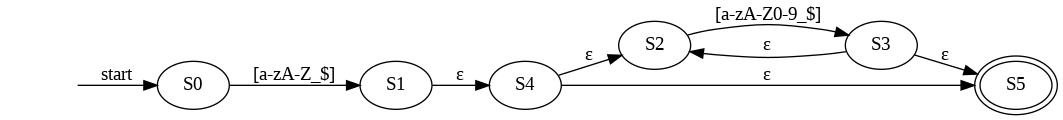


The DFA has 1 starting states, 1 inner states, and 2 accepting state


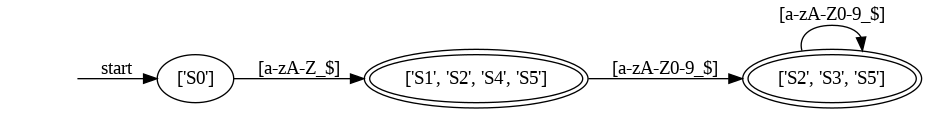


The DFA has 1 starting states, 1 inner states, and 2 accepting state


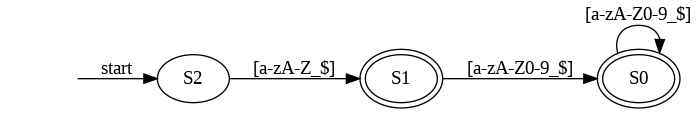


The DFA has 1 starting states, 1 inner states, and 1 accepting state


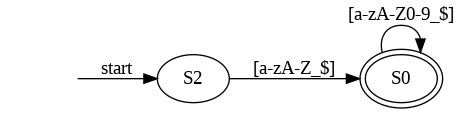

In [229]:
regex = input()
regex_to_minimized_DFA(regex)